<a href="https://colab.research.google.com/github/shreetishresthanp/ml_theory/blob/main/homework1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 1.1
First, generate two tasks from synthetic data distributions with dimension p = 100.
For instance, you may generate the covariate or feature vectors of each task from an isotropic
Gaussian. Then, generate the labels according to two linear models β(1), β(2) with a Gaussian
noise of mean zero and standard deviation 0.1.

In [8]:
def generate_data(p, n1, n2, n_test, delta, sigma, beta2, v, seed=None):
    if seed is not None:
        rng = np.random.RandomState(seed)
    else:
        rng = np.random.RandomState()

    beta1 = beta2 + delta * v

    # Source task (task 1)
    X1 = rng.randn(n1, p)
    y1 = X1 @ beta1 + sigma * rng.randn(n1)

    # Target task (task 2) - training
    X2 = rng.randn(n2, p)
    y2 = X2 @ beta2 + sigma * rng.randn(n2)

    # Target task (task 2) - test
    X2_test = rng.randn(n_test, p)
    y2_test = X2_test @ beta2 + sigma * rng.randn(n_test)

    return X1, y1, X2, y2, X2_test, y2_test, beta1

##1.2
Next, fix n1 = 200, n2 = 100, vary δ = β(1) − β(2) from 0.01 to 1.00. Implement
both the single-task or ordinary least squares (OLS) estimator and the hard transfer or hard
parameter sharing (HPS) estimator. Draw a plot by varying δ, and compare the test losses
of OLS and HPS estimators on task two.

In [9]:
def ols_estimator(X2, y2):
    beta_ols, _, _, _ = np.linalg.lstsq(X2, y2, rcond=None)
    return beta_ols

def hps_estimator(X1, y1, X2, y2):
    X_pooled = np.vstack([X1, X2])
    y_pooled = np.concatenate([y1, y2])
    beta_hps, _, _, _ = np.linalg.lstsq(X_pooled, y_pooled, rcond=None)
    return beta_hps

def test_mse(X_test, y_test, beta_hat):
    predictions = X_test @ beta_hat
    return np.mean((predictions - y_test) ** 2)

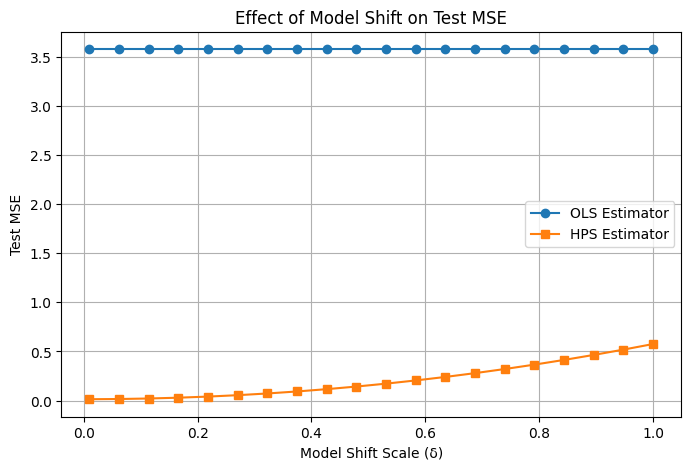

In [10]:
np.random.seed(42)
p = 100
sigma = 0.1
n1, n2, n_test = 200, 100, 1000

beta2 = np.random.randn(p)
v = np.random.randn(p)
v = v / np.linalg.norm(v)

deltas = np.linspace(0.01, 1.00, 20)
ols_losses = []
hps_losses = []

for delta in deltas:
    X1, y1, X2, y2, X2_test, y2_test, beta1 = generate_data(
        p, n1, n2, n_test, delta, sigma, beta2, v, seed=0
    )

    beta_ols = ols_estimator(X2, y2)
    beta_hps = hps_estimator(X1, y1, X2, y2)

    ols_losses.append(test_mse(X2_test, y2_test, beta_ols))
    hps_losses.append(test_mse(X2_test, y2_test, beta_hps))

plt.figure(figsize=(8, 5))
plt.plot(deltas, ols_losses, 'o-', label='OLS Estimator')
plt.plot(deltas, hps_losses, 's-', label='HPS Estimator')
plt.xlabel('Model Shift Scale (δ)')
plt.ylabel('Test MSE')
plt.title('Effect of Model Shift on Test MSE')
plt.legend()
plt.grid(True)
plt.savefig('part2_plot.png')
plt.show()

## 1.3
Next, implement the soft transfer or soft parameter sharing (SPS) estimator with
an additional regularization penalty placed on z in the objective function, which determines
the difference between models that we will use for task 1 vs. task 2. In particular, z is a
variable that you will optimize during the training process. Adjust the regularization hyper-
parameter λ associated with the regularization penalty, and report the best test loss from
varying λ.

In [11]:
def sps_estimator(X1, y1, X2, y2, lam):
    n1, p = X1.shape
    n2 = X2.shape[0]
    n = n1 + n2

    sqrt_n = np.sqrt(n)
    sqrt_lam = np.sqrt(lam)

    zeros_n2 = np.zeros((n2, p))

    # Variables are [beta, z] (length 2p)
    # Task 1 uses (beta + z), task 2 uses beta, penalty on z
    A = np.vstack([
        np.hstack([X1 / sqrt_n, X1 / sqrt_n]),              # task 1: X1(beta + z)
        np.hstack([X2 / sqrt_n, zeros_n2]),                  # task 2: X2(beta)
        np.hstack([np.zeros((p, p)), sqrt_lam * np.eye(p)])  # penalty on z
    ])

    b = np.concatenate([
        y1 / sqrt_n,
        y2 / sqrt_n,
        np.zeros(p)
    ])

    params, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    beta = params[:p]
    z = params[p:]

    return beta

In [12]:
lambdas = np.logspace(-4, 4, 50)
delta_fixed = 0.5  # pick a representative delta

X1, y1, X2, y2, X2_test, y2_test, _ = generate_data(
    p, n1, n2, n_test, delta_fixed, sigma, beta2, v, seed=0
)

best_loss = float('inf')
best_lam = None

for lam in lambdas:
    beta_sps = sps_estimator(X1, y1, X2, y2, lam)
    loss = test_mse(X2_test, y2_test, beta_sps)
    if loss < best_loss:
        best_loss = loss
        best_lam = lam

print(f"Best lambda: {best_lam:.6f}")
print(f"Best SPS test loss: {best_loss:.6f}")

Best lambda: 0.019307
Best SPS test loss: 0.090215


##1.4
 Finally, draw a plot by varying δ as in part 2, and compare the test losses of HPS
and SPS estimators on task two.

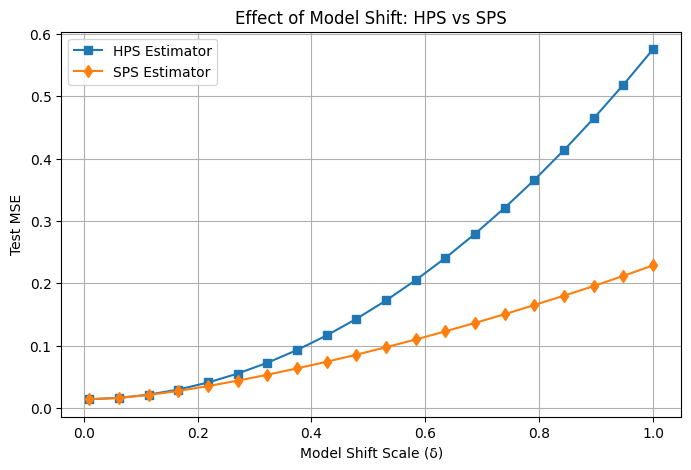

In [13]:
deltas = np.linspace(0.01, 1.00, 20)
hps_losses = []
sps_losses = []
lambdas = np.logspace(-4, 4, 50)

for delta in deltas:
    X1, y1, X2, y2, X2_test, y2_test, _ = generate_data(
        p, n1, n2, n_test, delta, sigma, beta2, v, seed=0
    )

    # HPS
    beta_hps = hps_estimator(X1, y1, X2, y2)
    hps_losses.append(test_mse(X2_test, y2_test, beta_hps))

    # SPS with best lambda
    best_loss = float('inf')
    for lam in lambdas:
        beta_sps = sps_estimator(X1, y1, X2, y2, lam)
        loss = test_mse(X2_test, y2_test, beta_sps)
        if loss < best_loss:
            best_loss = loss
    sps_losses.append(best_loss)

plt.figure(figsize=(8, 5))
plt.plot(deltas, hps_losses, 's-', label='HPS Estimator')
plt.plot(deltas, sps_losses, 'd-', label='SPS Estimator')
plt.xlabel('Model Shift Scale (δ)')
plt.ylabel('Test MSE')
plt.title('Effect of Model Shift: HPS vs SPS')
plt.legend()
plt.grid(True)
plt.savefig('part4_plot.png')
plt.show()

### Misc
Additional plot to show OLS vs HPS vs SPS in one chart


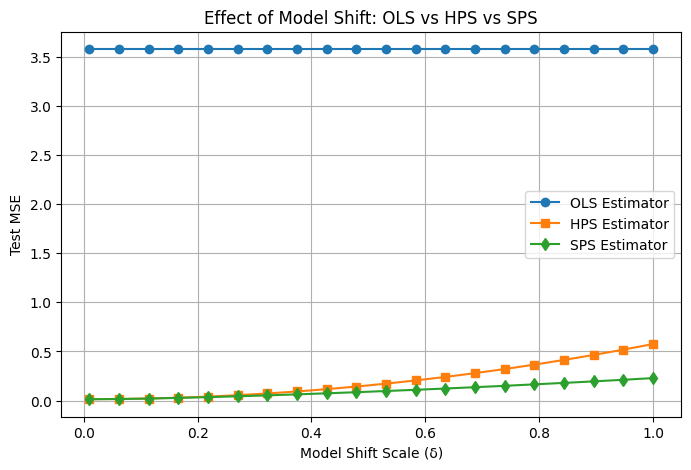

In [14]:
deltas = np.linspace(0.01, 1.00, 20)
ols_losses = []
hps_losses = []
sps_losses = []
lambdas = np.logspace(-4, 4, 50)

for delta in deltas:
    X1, y1, X2, y2, X2_test, y2_test, _ = generate_data(
        p, n1, n2, n_test, delta, sigma, beta2, v, seed=0
    )

    # OLS
    beta_ols = ols_estimator(X2, y2)
    ols_losses.append(test_mse(X2_test, y2_test, beta_ols))

    # HPS
    beta_hps = hps_estimator(X1, y1, X2, y2)
    hps_losses.append(test_mse(X2_test, y2_test, beta_hps))

    # SPS with best lambda
    best_loss = float('inf')
    for lam in lambdas:
        beta_sps = sps_estimator(X1, y1, X2, y2, lam)
        loss = test_mse(X2_test, y2_test, beta_sps)
        if loss < best_loss:
            best_loss = loss
    sps_losses.append(best_loss)

plt.figure(figsize=(8, 5))
plt.plot(deltas, ols_losses, 'o-', label='OLS Estimator')
plt.plot(deltas, hps_losses, 's-', label='HPS Estimator')
plt.plot(deltas, sps_losses, 'd-', label='SPS Estimator')
plt.xlabel('Model Shift Scale (δ)')
plt.ylabel('Test MSE')
plt.title('Effect of Model Shift: OLS vs HPS vs SPS')
plt.legend()
plt.grid(True)
plt.savefig('all_estimators_plot.png')
plt.show()

## 2.3
Validate the above two facts in simulations. Implement a numpy function that
simulates the empirical histogram of the Gaussian distribution by drawing (say, 1000) random
samples. Then, compare the histograms of cX (of variance σ2
x) with another Gaussian whose
variance is c2σ2
x.
Also compare X + Y with another Gaussian whose variance is σ2
x + σ2
y .

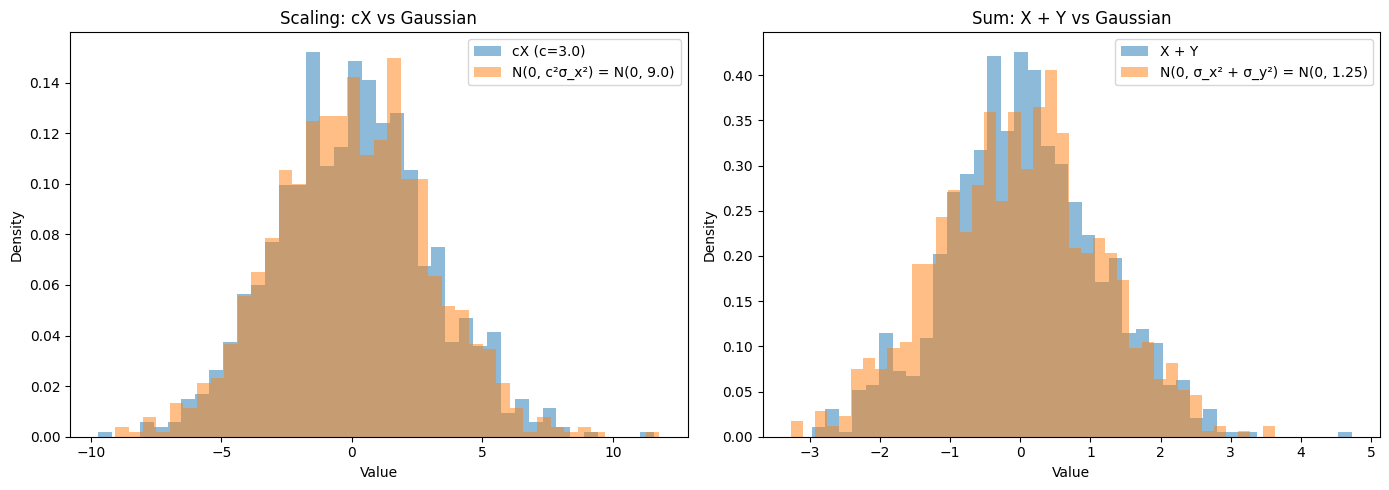

In [15]:
np.random.seed(42)
n_samples = 1000

sigma_x = 1.0
sigma_y = 0.5
c = 3.0

# Draw sub-Gaussian samples (Gaussian is sub-Gaussian with same parameter)
X = np.random.normal(0, sigma_x, n_samples)
Y = np.random.normal(0, sigma_y, n_samples)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Part 1: cX vs Gaussian with variance c^2 * sigma_x^2
cX = c * X
gaussian_cx = np.random.normal(0, c * sigma_x, n_samples)

axes[0].hist(cX, bins=40, alpha=0.5, density=True, label=f'cX (c={c})')
axes[0].hist(gaussian_cx, bins=40, alpha=0.5, density=True,
             label=f'N(0, c²σ_x²) = N(0, {c**2 * sigma_x**2})')
axes[0].set_title('Scaling: cX vs Gaussian')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

# Part 2: X + Y vs Gaussian with variance sigma_x^2 + sigma_y^2
XplusY = X + Y
sigma_sum = np.sqrt(sigma_x**2 + sigma_y**2)
gaussian_sum = np.random.normal(0, sigma_sum, n_samples)

axes[1].hist(XplusY, bins=40, alpha=0.5, density=True, label='X + Y')
axes[1].hist(gaussian_sum, bins=40, alpha=0.5, density=True,
             label=f'N(0, σ_x² + σ_y²) = N(0, {sigma_x**2 + sigma_y**2})')
axes[1].set_title('Sum: X + Y vs Gaussian')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.savefig('subgaussian_validation.png')
plt.show()